In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dcm

## **Reading the Data Set and EDA**

In [2]:
## reading the labels data set and showing first few records
labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
labels.shape
## There are 30227 records and 6 rows

(30227, 6)

In [4]:
labels.info()
## There are 30227 rows 
## there are 30277 target as well
## x ,y, WIdth and height count is 9555 , the others are null

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 30227 entries, 0 to 30226

Data columns (total 6 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   patientId  30227 non-null  object 

 1   x          9555 non-null   float64

 2   y          9555 non-null   float64

 3   width      9555 non-null   float64

 4   height     9555 non-null   float64

 5   Target     30227 non-null  int64  

dtypes: float64(4), int64(1), object(1)

memory usage: 1.4+ MB


In [5]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [6]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [7]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

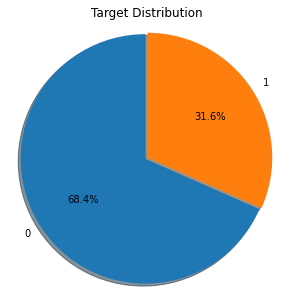

In [8]:
## Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia
## There is a class imbalance issue
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [9]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)
## There is no point in finding unique for x,y,width and height as there can be duplcaie values in them
## There are duplicate patients in the data set

Are there Unique Patients In Data Set ??  False


In [10]:
#labels.loc[labels.index.repeat(labels.patientId)]
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

## There are 3543 duplicates

(3543, 6)

In [11]:
duplicateRowsDF.head(2)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [12]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [13]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

,patientId,x,y,width,height,Target
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


# **Reading the class Info Data Set**

In [14]:
## Reading the classes label , 
class_labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
class_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [15]:
class_labels.shape
## There are 30277 rows and two columns , 30277 rows same as the labels data set

(30227, 2)

In [16]:
class_labels.info()
## There are no null columns 

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 30227 entries, 0 to 30226

Data columns (total 2 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   patientId  30227 non-null  object

 1   class      30227 non-null  object

dtypes: object(2)

memory usage: 472.4+ KB


In [17]:
class_labels['class'].value_counts()

## there are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

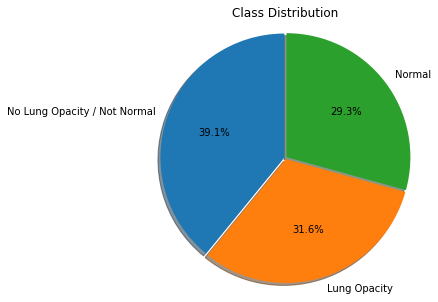

In [18]:
## Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
## and the remaining are with Lung Opacity
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [19]:

#labels.loc[labels.index.repeat(labels.patientId)]
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

## There are 3543 duplicates similar to the labels dataset

(3543, 2)

In [20]:
duplicateClassRowsDF.head(2)

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [21]:
## The same patient id has the same class even though they are duplicate
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

,patientId,class
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


Merging the class and labels data set into training dataset

In [22]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Text(0.5, 1.0, 'Class and Target  Distrubution')

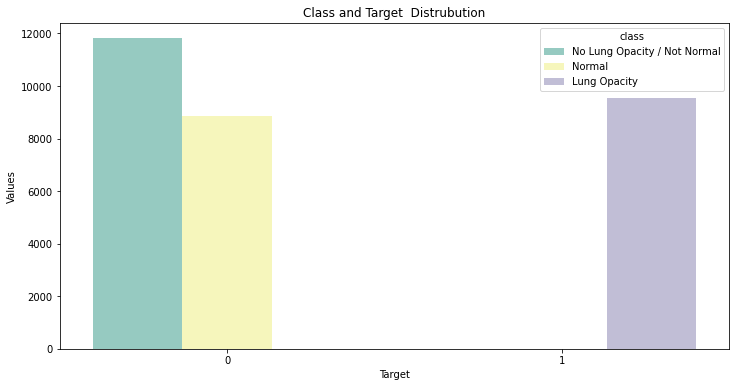

In [23]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [24]:
## ANalysing the dicom image
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Displaying Chest Xray Images of Patients who have Pneuomina

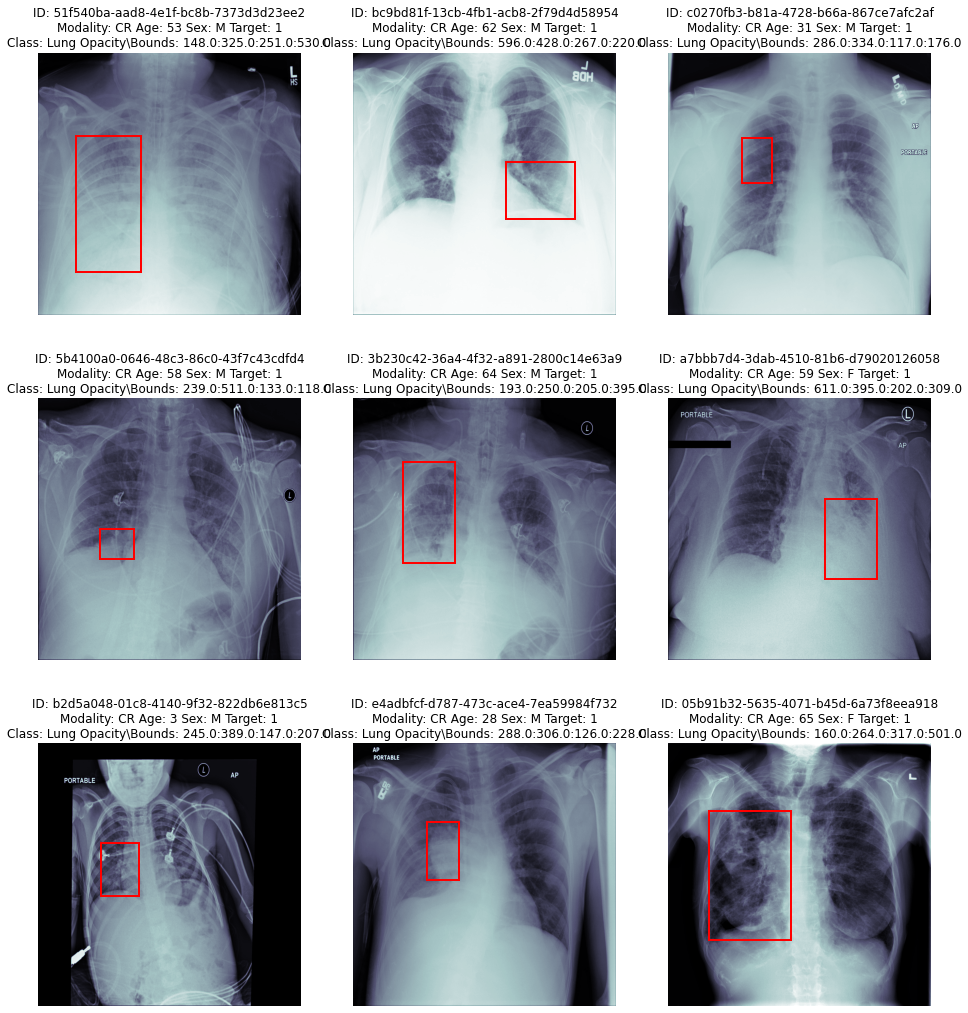

In [25]:
## checking few images which has pneuonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

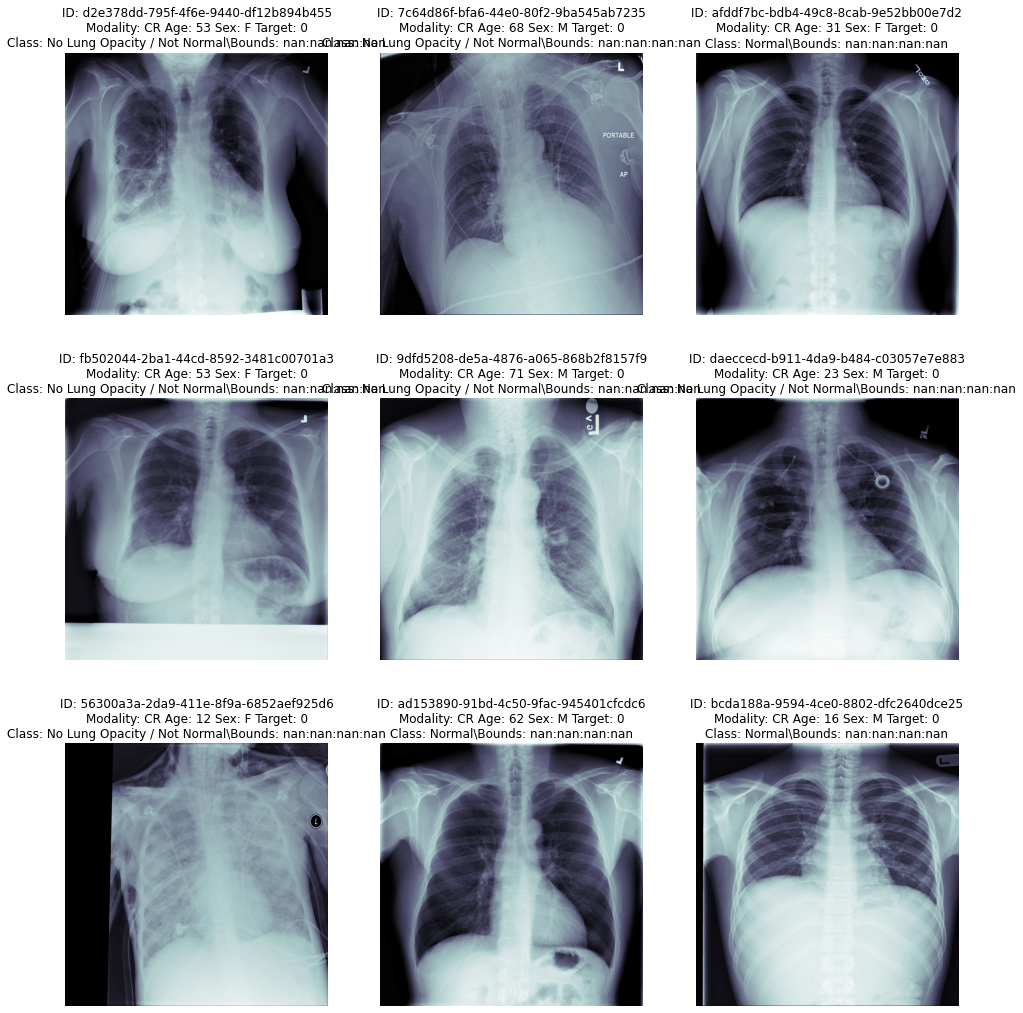

In [26]:
## checking few images which does not have pneuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))

Reading the Dicom images meta data and appending it to the training set

In [71]:
training_data = pd.read_csv('https://raw.githubusercontent.com/rahultheogre/Capstone-RSNA-Pneumonia-Detection/main/pneumonia_ds.csv')

In [50]:
training_data.info()
## There are 30227  records
## sex and age also have the smae count indicating that there are no images missing every patient has an dicom image 
## Age should be a numeric , currently it is an objetc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   30227 non-null  object 
 1   x           9555 non-null   float64
 2   y           9555 non-null   float64
 3   width       9555 non-null   float64
 4   height      9555 non-null   float64
 5   Target      30227 non-null  int64  
 6   class       30227 non-null  object 
 7   boxes       30227 non-null  int64  
 8   PatientAge  30227 non-null  int64  
 9   PatientSex  30227 non-null  object 
 10  ImagePath   30227 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.5+ MB


In [51]:
training_data.describe(include="all").T
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boxes,30227.0,NaN,NaN,NaN,1.24488,0.467829,1.0,1.0,1.0,1.0,4.0
PatientAge,30227.0,NaN,NaN,NaN,46.797764,16.89294,1.0,34.0,49.0,59.0,155.0
PatientSex,30227,2,M,17216,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
training_data.PatientSex.value_counts()
## there are only two genders 

M    17216
F    13011
Name: PatientSex, dtype: int64

Text(0.5, 1.0, 'PatientSex and Target for Chest Exams')

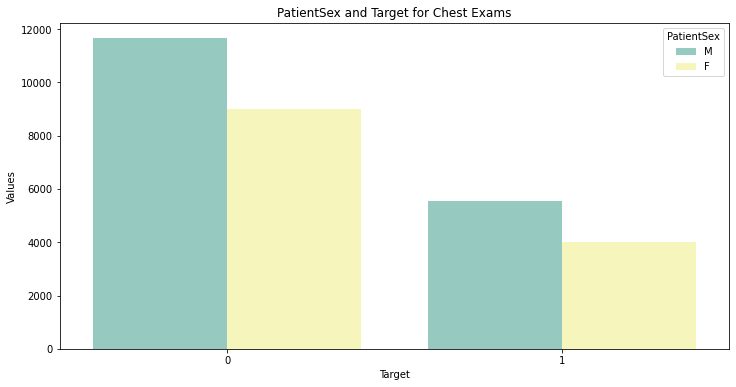

In [53]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('PatientSex and Target for Chest Exams')

## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

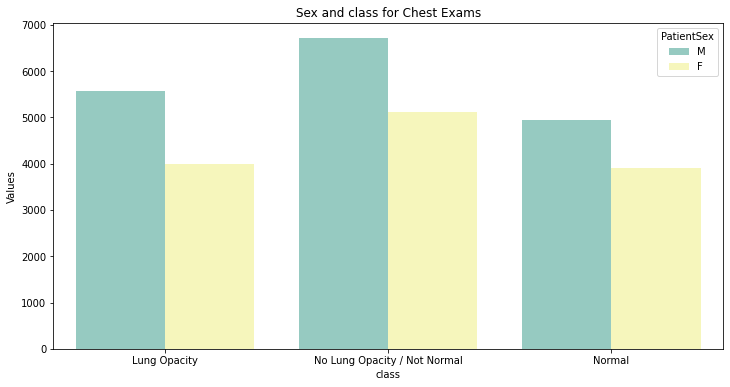

In [54]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

## the number of males in all classes are higher than women

<AxesSubplot:xlabel='PatientAge', ylabel='Density'>

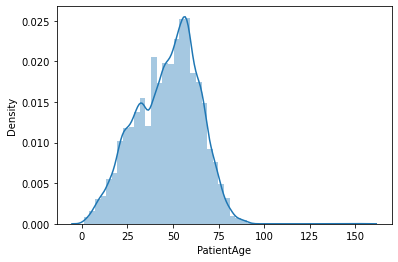

In [55]:
sns.distplot(training_data.PatientAge) 
# plots the distrubution of age
## Looks like normal distubution of age

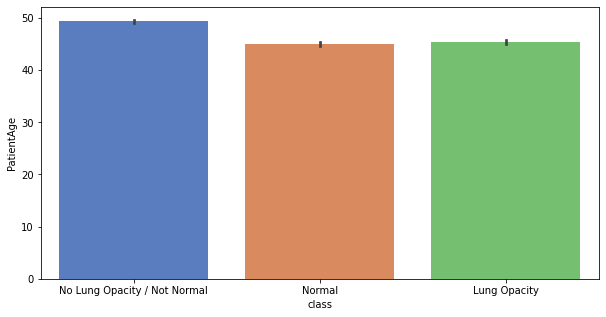

In [56]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='PatientAge', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

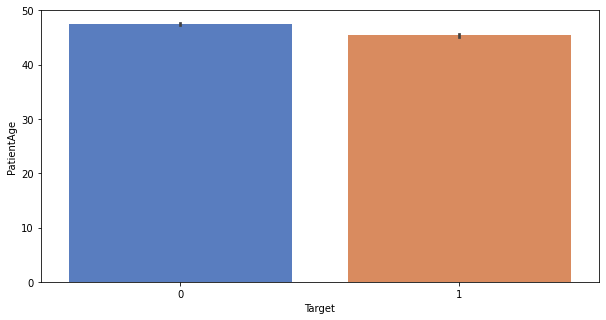

In [57]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='PatientAge', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

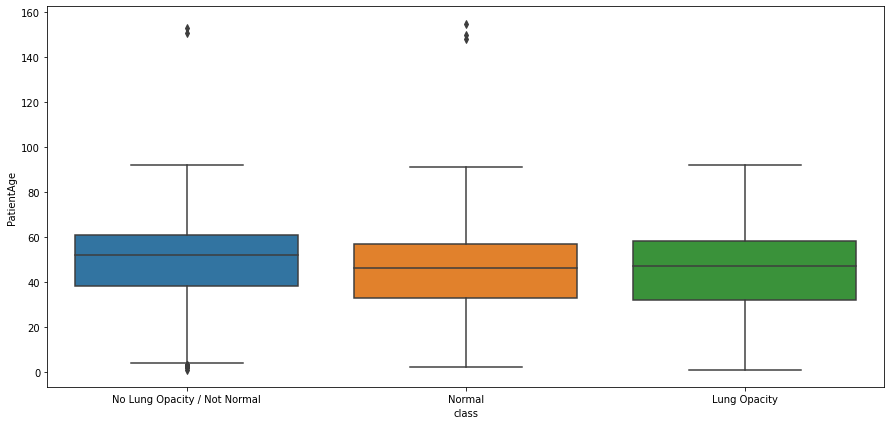

In [58]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='PatientAge', data= training_data)
plt.show()

## The  class which has no pneuomia has few outliers , theie age is somewhere aroun 150 years

Distribution of `Age`: Overall and Target = 1


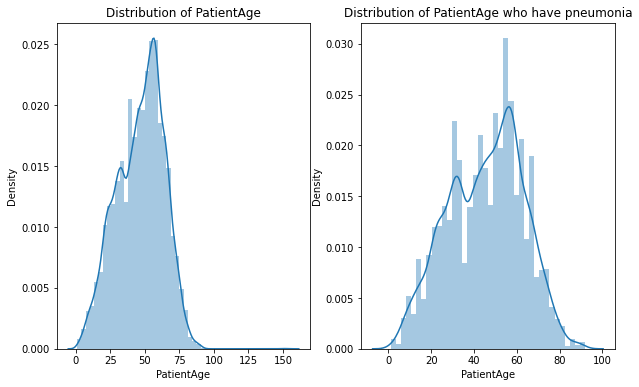

In [59]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge who have pneumonia'))

## Overall Distrubution of Age looks normal with very little skwe
## Distubution of Patients afe who have penuomonia are a left skewed 

<AxesSubplot:>

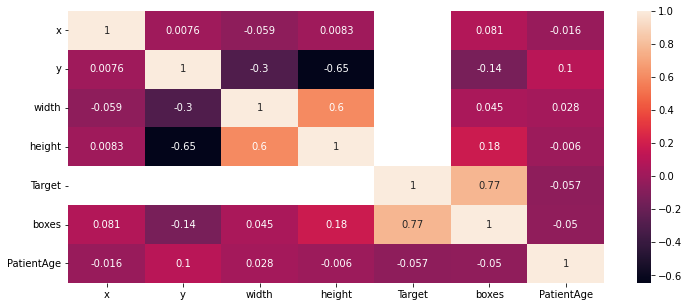

In [60]:
corr = training_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

## There is high corelation between widht and height


### **MODEL BUILDING**

In [72]:
## Taking a 1000 samples each class of the dataset
training_data = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(1000))

In [73]:
## Checking the training data set with class distbution 
training_data["class"].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal    1000
Normal                          1000
Name: class, dtype: int64

In [74]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 29168 to 19123
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   3000 non-null   object 
 1   x           1000 non-null   float64
 2   y           1000 non-null   float64
 3   width       1000 non-null   float64
 4   height      1000 non-null   float64
 5   Target      3000 non-null   int64  
 6   class       3000 non-null   object 
 7   boxes       3000 non-null   int64  
 8   PatientAge  3000 non-null   int64  
 9   PatientSex  3000 non-null   object 
 10  ImagePath   3000 non-null   object 
dtypes: float64(4), int64(3), object(4)
memory usage: 281.2+ KB


In [75]:
images = []
ADJUSTED_IMAGE_SIZE = 224
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [76]:
## Reading the images into numpy array
images,labels = populateImage(training_data)

In [78]:
del training_data

In [77]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((3000, 224, 224, 3), (3000,))

In [79]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(labels)

In [80]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=42)

In [ ]:
del images

In [81]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

# Inception V3

In [86]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train) 
val_ds = preprocess_input(X_val)

87924736/87910968 [==============================] - 1s 0us/step


In [88]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


inceptionv3_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [89]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

In [92]:
inceptionv3_model.compile(
    optimizer=Adam (0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


history = inceptionv3_model.fit(train_ds, y_train, epochs=15, validation_data=(val_ds,y_val) ,callbacks=callbacks)

2022-11-26 00:23:00.224821: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1264435200 exceeds 10% of free system memory.
2022-11-26 00:23:01.712996: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1264435200 exceeds 10% of free system memory.


Epoch 1/15
66/66 [==============================] - 42s 151ms/step - loss: 1.4730 - accuracy: 0.4962 - val_loss: 0.5500 - val_accuracy: 0.5822
Epoch 2/15
66/66 [==============================] - 7s 99ms/step - loss: 0.4743 - accuracy: 0.6548 - val_loss: 0.4951 - val_accuracy: 0.6511
Epoch 3/15
66/66 [==============================] - 6s 98ms/step - loss: 0.3986 - accuracy: 0.7252 - val_loss: 0.4888 - val_accuracy: 0.6511
Epoch 4/15
66/66 [==============================] - 7s 100ms/step - loss: 0.3398 - accuracy: 0.7857 - val_loss: 0.5514 - val_accuracy: 0.6400
Epoch 5/15
66/66 [==============================] - 6s 97ms/step - loss: 0.2733 - accuracy: 0.8486 - val_loss: 0.5271 - val_accuracy: 0.6222
Epoch 6/15
66/66 [==============================] - 6s 97ms/step - loss: 0.2352 - accuracy: 0.8648 - val_loss: 0.6249 - val_accuracy: 0.6044


With each epoch, the accuracy is going down. The model needs tuning.

In [95]:
test_ds = preprocess_input(X_test) 
fcl_loss, fcl_accuracy = inceptionv3_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## The Test accuracy score if 64% but the training accurayc is 100 , this model is overfit

15/15 [==============================] - 1s 80ms/step - loss: 0.4739 - accuracy: 0.6489
Test loss: 0.4739140272140503
Test accuracy: 0.648888885974884


Let us fine tune the model with a few Batchnormalization and dropout layers.

In [101]:
from keras.layers import BatchNormalization


flatten_layer = layers.Flatten()
bn_features = BatchNormalization()
gap = GlobalAveragePooling2D()
drop1 = Dropout(0.5)
dense_layer_1 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


inceptionv3_model_1 = models.Sequential([
    base_model,
    bn_features,
    gap,
    drop1,
    dense_layer_1,
    prediction_layer
])

In [102]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

In [103]:
inceptionv3_model_1.compile(
    optimizer=Adam (0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


history = inceptionv3_model_1.fit(train_ds, y_train, epochs=50, validation_data=(val_ds,y_val) ,callbacks=callbacks)

Epoch 1/50
66/66 [==============================] - 12s 122ms/step - loss: 0.5681 - accuracy: 0.5743 - val_loss: 0.5298 - val_accuracy: 0.5867
Epoch 2/50
66/66 [==============================] - 6s 94ms/step - loss: 0.4601 - accuracy: 0.6686 - val_loss: 0.4929 - val_accuracy: 0.6178
Epoch 3/50
66/66 [==============================] - 6s 97ms/step - loss: 0.4084 - accuracy: 0.7138 - val_loss: 0.5092 - val_accuracy: 0.6111
Epoch 4/50
66/66 [==============================] - 6s 98ms/step - loss: 0.3785 - accuracy: 0.7410 - val_loss: 0.5130 - val_accuracy: 0.6311
Epoch 5/50
66/66 [==============================] - 7s 100ms/step - loss: 0.3423 - accuracy: 0.7743 - val_loss: 0.5210 - val_accuracy: 0.6289
Epoch 6/50
66/66 [==============================] - 6s 98ms/step - loss: 0.3279 - accuracy: 0.7890 - val_loss: 0.5585 - val_accuracy: 0.6111
Epoch 7/50
66/66 [==============================] - 6s 95ms/step - loss: 0.3159 - accuracy: 0.8043 - val_loss: 0.5486 - val_accuracy: 0.6156
Epoch 8/50

In [104]:
fcl_loss, fcl_accuracy = inceptionv3_model_1.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
## The Test accuracy score if 64% but the training accurayc is 100 , this model is overfit

15/15 [==============================] - 1s 74ms/step - loss: 0.5161 - accuracy: 0.5911
Test loss: 0.5161396265029907
Test accuracy: 0.5911111235618591


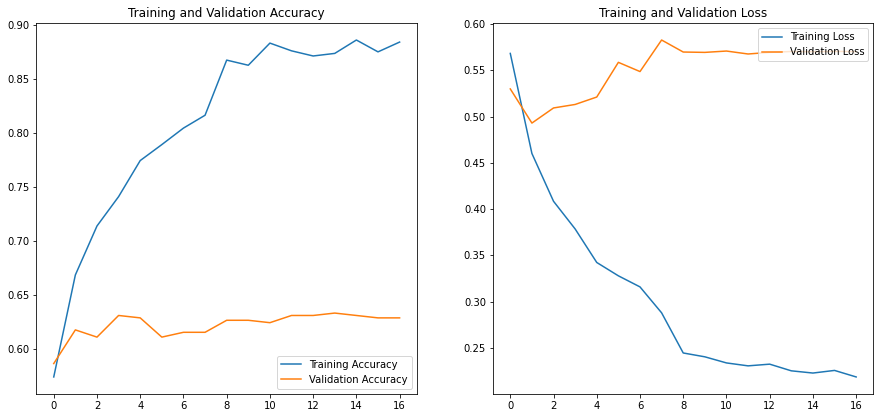

In [108]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(17)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.


In [109]:
resultDF = createResultDf("Inceptionv3",acc[-1],fcl_accuracy)

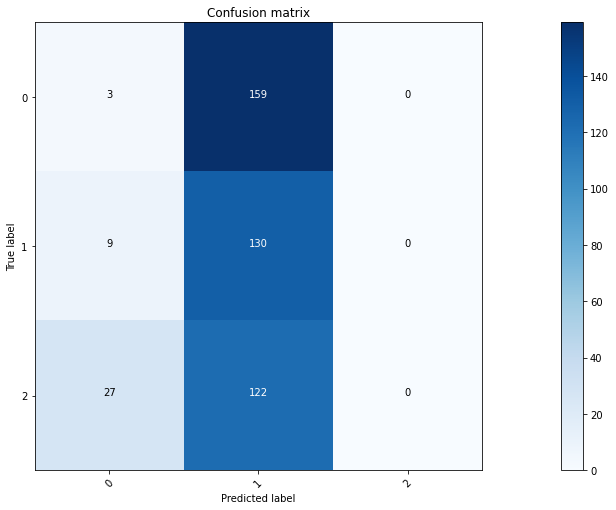

In [113]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
# Predict the values from the validation dataset
Y_pred = inceptionv3_model_1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [114]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = inceptionv3_model_1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,Inceptionv3,0.88381,0.591111,0.316302,0.935252,0.472727,139
